In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
from collections import namedtuple
from operator import itemgetter
from helpers.features import read_offset_csv, transform_offsets_to_paths, show_image, precision_and_recall, timeit
from helpers.pipeline import build_page_df, read_image, detect_and_extract, calculate_metrics
from helpers.pipeline import applymapi, find_matches, select_keypoints, compute_homography_and_mask, sum_homography_mask, filter_out_bad_homographies

In [3]:
BukanResults = namedtuple("BukanResults", ["paths", "pages", "keypoints", "descriptors", "matches",
                                           "selected_keypoints", "selected_keypoints_masks",
                                           "homographies", "homography_masks", "filtered_homography_masks",
                                           "sums", "times"])

In [4]:
def run_full_pipeline(csv_path):
    ground_truth = read_offset_csv(csv_path)
    paths = transform_offsets_to_paths(ground_truth)
    page_df = build_page_df(ground_truth)
    
    detector = cv.AKAZE_create(cv.AKAZE_DESCRIPTOR_MLDB_UPRIGHT, descriptor_size=0, threshold=0.005)
    detect_time_s, (keypoints, descriptors) = detect_and_extract(paths, detector)

    matcher = cv.BFMatcher_create(normType=cv.NORM_HAMMING)
    match_time_s, matches_df = applymapi(
        page_df, find_matches, max_distance=100, descriptors=descriptors, matcher=matcher)

    wradius = 280.
    hradius = 164.
    def is_near(pt1, pt2):
        x1, y1 = pt1
        x2, y2 = pt2
        return ((x1 - wradius) <= x2 <= (x1 + wradius)) and ((y1 - hradius) <= y2 <= (y1 + hradius))
    select_time_s, selected_keypoints_df = applymapi(page_df, select_keypoints, matches=matches_df, keypoints=keypoints, filter=is_near)
    
    homography_time_s, (homography_df, hmask_df) = compute_homography_and_mask(
        selected_keypoints_df.applymap(itemgetter(0)))
    
    filter_time, filtered_masks = filter_out_bad_homographies(homography_df, hmask_df)
    hmask_sum_df = sum_homography_mask(filtered_masks)
    
    return BukanResults(paths, page_df, keypoints, descriptors, matches_df,
                        selected_keypoints_df.applymap(itemgetter(0)),
                        selected_keypoints_df.applymap(itemgetter(1)),
                        homography_df, hmask_df, filtered_masks, hmask_sum_df,
                        [detect_time_s, match_time_s, select_time_s, homography_time_s, filter_time])

In [5]:
shuuchin1_results = run_full_pipeline("annotations/shuuchinbukan-1.csv")

In [ ]:
shuuchin2_results = run_full_pipeline("annotations/shuuchinbukan-2.csv")

In [ ]:
shuuchin3_results = run_full_pipeline("annotations/shuuchinbukan-3.csv")

In [ ]:
thresholds = np.arange(20, 61)

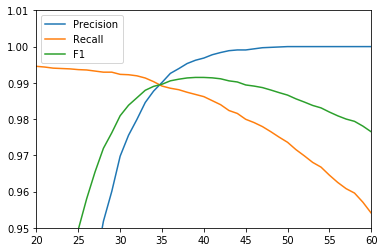

In [19]:
calculate_metrics(shuuchin1_results.sums, thresholds).plot(ylim=(0.95, 1.01))

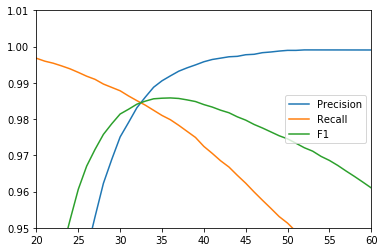

In [20]:
calculate_metrics(shuuchin2_results.sums, thresholds).plot(ylim=(0.95, 1.01))

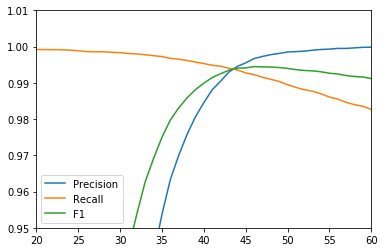

In [21]:
calculate_metrics(shuuchin3_results.sums, thresholds).plot(ylim=(0.95, 1.01))

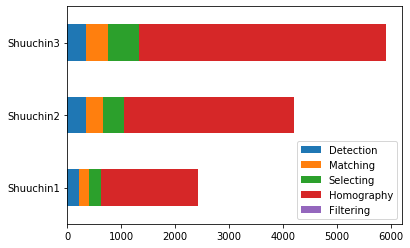

In [22]:
pd.DataFrame([shuuchin1_results.times, shuuchin2_results.times, shuuchin3_results.times],
             index=["Shuuchin1", "Shuuchin2", "Shuuchin3"],
             columns=["Detection", "Matching", "Selecting", "Homography", "Filtering"]).plot.barh(stacked=True)

In [1]:
def draw_relevant_matches(bukanResults, book1_id, book1_page, book2_id, book2_offset):
    """
    This whole function is quite convoluted since I need to "undo" all operations to
    find out which matches don't matter anymore at the end. These matches are selected
    and then visualized in a side-by-side comparison.
    """
    img1_path = bukanResults.paths[book1_id][book1_page]
    img1 = read_image(img1_path)
    kp1 = bukanResults.keypoints[book1_id][book1_page]

    book2_page = bukanResults.pages.loc[(book1_id, book2_id, book1_page), book2_offset]
    img2_path = bukanResults.paths[book2_id][book2_page]
    img2 = read_image(img2_path)
    kp2 = bukanResults.keypoints[book2_id][book2_page]

    selected_keypoints = bukanResults.selected_keypoints.loc[(book1_id, book2_id, book1_page), book2_offset]
    selected_keypoints_mask = bukanResults.selected_keypoints_masks.loc[(book1_id, book2_id, book1_page), book2_offset]
    homography_mask = bukanResults.homography_masks.loc[(book1_id, book2_id, book1_page), book2_offset]

    kp_mask = np.empty_like(selected_keypoints_mask, dtype=np.bool)
    assert selected_keypoints_mask.sum() == homography_mask.size
    counter = 0
    for i, kp_bool in enumerate(selected_keypoints_mask):
        if kp_bool:
            kp_mask[i] = homography_mask[counter]
            counter += 1
        else:
            kp_mask[i] = False
    assert counter == selected_keypoints_mask.sum()
    
    matches = bukanResults.matches.loc[(book1_id, book2_id, book1_page), book2_offset]
    assert len(matches) == kp_mask.size
    relevant_matches = [matches[i] for i, val in enumerate(kp_mask) if val]
    assert len(relevant_matches) == kp_mask.sum()

    return cv.drawMatches(img1, kp1, img2, kp2, matches, None)

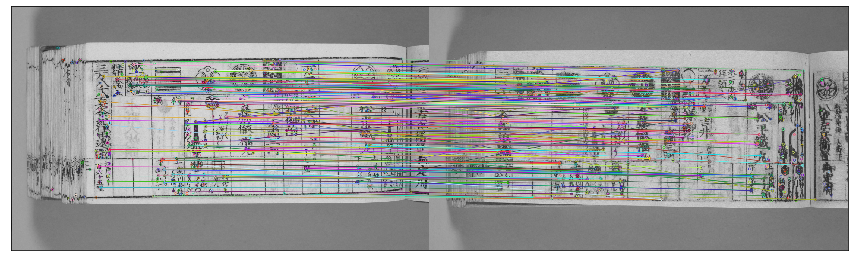

In [24]:
match_img = draw_relevant_matches(shuuchin1_results, "200019527", 9, "200019558", 0)
show_image(match_img, (15, 15))

In [25]:
img1_path = shuuchin1_results.paths["200019527"][9]
img1 = read_image(img1_path)
book2_page = shuuchin1_results.pages.loc[("200019527", "200019558", 9), 0]
img2_path = shuuchin1_results.paths["200019558"][9]
img2 = read_image(img2_path)
homography = shuuchin1_results.homographies.loc[("200019527", "200019558", 9), 0]

In [26]:
height, width = img2.shape
img1_new = cv.warpPerspective(img1, homography, (width, height))[100:-100,100:-100]
img2_new = img2[100:-100,100:-100]

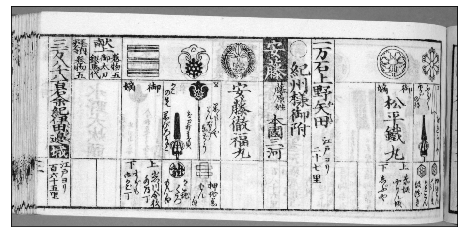

In [27]:
show_image(img1_new)

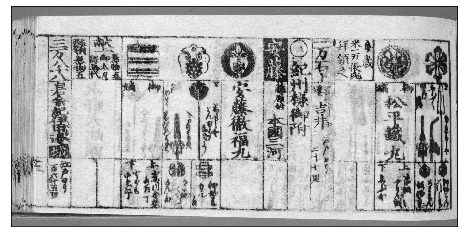

In [28]:
show_image(img2_new)